In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Import the necessary libraries
## This list will get modified as needed

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import *
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import *
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
## Confirm the versions of Keras and Tensorflow - to confirm we have the most up to date
## We should see 2.3 and 2.0 and .24.2

print(keras.__version__)
print()
print(tf.__version__)
print()
print(pd.__version__)

2.3.0

2.0.0

0.24.2


In [4]:
## Remove annoying DeprecationWarnings from sklearn - I will upgrade after this project!

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
## List the different files we have available in the Group Project folder
## The main files that we need for this analysis are:

import os

#print(os.listdir("D:\\Group Project - Google\\datasets"))

In [7]:
## Set the working directory

## Working directory - for MSBA 6420 Virtual Machine
working_dir = "D:\\Group 1\\datasets\\"

## Working directory - for MSBA 6410 Virtual Machine
##working_dir = "D:\\Group Project - Google\\datasets\\"

## Training Data File - with flattened JSON fields
training_file = "train-flattened.csv"

## Full path to train data file
training_path = working_dir+training_file

## Testing Data File - first version
## testing_file = "test-flattened.csv"

## Full path to test data file
## testing_path = working_dir+testing_file

## Submission Data File - with subset of VisitorIds
submission_file = "sample_submission_v2.csv"

## Full path to submission file
submission_path = working_dir+submission_file

## New testing data file
testing_file_v2 = "test_2-flattened.csv"

testing_v2_path = working_dir+testing_file_v2

In [8]:
## Verify the training and testing paths

print(training_path)

print()

print(testing_v2_path)

D:\Group 1\datasets\train-flattened.csv

D:\Group 1\datasets\test_2-flattened.csv


## Here are the features that we've identified as the most important for our model:

1. visitNumber
2. date
3. total.hits
4. totalspageviews
5. geoNetwork.cty 
6. geoNetwork.state
7. traffic source

In [9]:
## Load in the training data from the flattened CSV file
training_data = pd.read_csv(training_path, low_memory = False)

In [10]:
## Confirm that our original training data is loaded

training_data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [11]:
## See the shape of the training data - to know how many dimension/features we have available
training_data.shape

(903653, 55)

In [12]:
## Fill transaction revenue column, our target, with zeros and convert to floating point measurement
target = training_data["totals.transactionRevenue"].fillna(0).astype(float)

## One of the most vital steps - transform the new target variable to 
target = target.apply(lambda x: np.log1p(x))

In [13]:
## Set a new variable with the columns we identified in our feature analysis
final_feature_cols = ["visitNumber", "date", "totals.hits", "totals.pageviews", 
                      "geoNetwork.city", "geoNetwork.country", "trafficSource.source"]

In [14]:
## Subset our new training data
new_train_data = training_data[final_feature_cols]

## Confirm the shape matches our original set of training data
print(new_train_data.shape)

(903653, 7)


In [15]:
## Set up a for loop to go through the columns in our new training data set
## If the data type is object - this means it is a categorical feature
## For the columns that contain categorical feature, we use factorize to transfrom them to numeric values
## This transformation happens "inplace" - we will overwrite the original columns with the newly factorized features

for col in new_train_data.columns:
    if new_train_data[col].dtypes == object:
        new_train_data[col], indexer = pd.factorize(new_train_data[col])

In [16]:
## One additonal step - fill the null/empty values for the "pageviews" column with zeros
## Then we transform this field into an integer field so that we have no floating point values left in our training data

new_train_data["totals.pageviews"] = new_train_data["totals.pageviews"].fillna(0).astype(int)

In [17]:
## Confirm that all of our datatypes are integer - this is needed for the LGB model

new_train_data.dtypes

visitNumber             int64
date                    int64
totals.hits             int64
totals.pageviews        int32
geoNetwork.city         int64
geoNetwork.country      int64
trafficSource.source    int64
dtype: object

In [18]:
## Create our "X" variable that contains all the features we would like to use for our model
X = np.array(new_train_data)

## Create our second "y" variable - for our regression problem using our new target variable
y_regression = np.array(target)

In [19]:
## Split data training 85 % and testing 15%
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X, y_regression, 
                                                                    test_size = 0.15, random_state = 42)

In [20]:
## Just confirming how much data we have to train and validate against
print("Train shape: {}".format(X_train_reg.shape))
print()
print("Validation shape: {}".format(X_val_reg.shape))

Train shape: (768105, 7)

Validation shape: (135548, 7)


In [21]:
## Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

## Define our own function for calculating the RMSE
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

# Appendix B.  Model Testing

In [22]:
## Transform our training data using RobustScaler object
## We have to reshape the training data because it is a flat array, and the RobustScaler object is expecting a 2-D array

X_train_reg_robust = preprocessing.RobustScaler().fit_transform(X_train_reg)

X_val_reg_robust = preprocessing.RobustScaler().fit_transform(X_val_reg)

y_train_reg_robust = preprocessing.RobustScaler().fit_transform(y_train_reg.reshape(-1, 1))

## We then flatten the transformed target back to its original state
y_train_reg_robust = y_train_reg_robust.flatten()

y_val_reg_robust = preprocessing.RobustScaler().fit_transform(y_val_reg.reshape(-1, 1))

## We then flatten the transformed target back to its original state
y_val_reg_robust = y_val_reg_robust.flatten()

In [23]:
print(X_train_reg_robust.shape)
print()
print(y_train_reg_robust.shape)

(768105, 7)

(768105,)


## Gradient Boost Timing

In [24]:
## Set up a cross validation grid for GBoost
### Use least squares loss for our regression
gbr_p_grid = {'loss': ['lad'], 
                 'n_estimators': [100, 200]}

## Set a number of trials to run for the models
num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_gbr = np.zeros(num_trials)

## Initiate a new Gradient Boost instance - to use in the nested cross validation step
gbr = ensemble.GradientBoostingRegressor()

In [ ]:
%%time
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    gbreg= GridSearchCV(estimator=gbr, n_jobs = 8, param_grid=gbr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error", verbose = 2)
    gbreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(gbreg, X = X_train_reg_robust, y = y_train_reg_robust, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_gbr[i] = nested_score.mean()

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.8min remaining:  3.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.2min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.2min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.2min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.1min remaining:  3.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.3min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   56.6s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.6s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.7s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.8s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.0s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.5min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.4s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.0s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.8s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.2s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   56.9s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.7s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.0s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.6s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.9s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.0s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   56.4s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.9s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.4s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.8s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.2s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.5s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.2s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.4s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.8s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.7s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.9s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.2s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.2s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   56.9s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.1s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.8s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.6s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.4s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   58.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.7s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   57.3s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.6min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.1min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.1min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.1min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   59.7s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.0min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min finished


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
nested_scores_gbr

## DecisionTree Timing

In [26]:
## Initiate a new instance of Decision Tree Regressor
dtr = tree.DecisionTreeRegressor()

## Set up a grid for the DecisionTree Regressor
dtr_p_grid = {"criterion": ["mse"],
            "splitter": ["best", "random"],
            "max_features": [4, 5, 6],
            "max_depth": [5, 10, 15]}

## Set a number of trials to run for the models
num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_dtr = np.zeros(num_trials)

In [30]:
%%time

## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for DecisionTree Regressor
    
    dtreg= GridSearchCV(estimator=dtr, param_grid=dtr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error", verbose = 2)
    dtreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(dtreg, X = X_train_reg_robust, y = y_train_reg_robust, 
                                   cv = outer_cv, scoring = "neg_mean_squared_error")
    
    nested_scores_dtr[i] = nested_score.mean()

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.3min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.2s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   59.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   57.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   1.0s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.2s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   52.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   57.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   1.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   57.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.5s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   52.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.2s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   57.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   52.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   51.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.5s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.2s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   57.2s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.6s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.7s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.5s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.4s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.8s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   1.0s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.9s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   56.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   55.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.9s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.5s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=best .......
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=best, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, max_depth=5, max_features=4, splitter=random, total=   0.1s
[CV] criterion=mse, max_depth=5, max_features=4, splitter=random .....
[CV]  criterion=mse, ma

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   54.1s finished


Wall time: 1h 45min 16s


In [46]:
training_time_dt = "1h 45min 16s"

print("Training time for Decision Tree Regression: {}".format(training_time_dt))
print()

print("Decision Tree Nested MSE Scores:")
print()

dt_scores = nested_scores_dtr*-1
lowest_score = min(dt_scores)
lowest_rmse = np.sqrt(lowest_score)

print(dt_scores)
print()

print("The lowest MSE achieved by Decision Tree: {}".format(lowest_score))
print()

print("The lowest RMSE achieved by Decision Tree: {}".format(lowest_rmse))

Training time for Decision Tree Regression: 1h 45min 16s

Decision Tree Nested MSE Scores:

[2.96643282 2.96986224 2.95867769 2.97241366 2.96661171 2.96888347
 2.93221285 2.96128329 2.97005955 2.96832082 2.97398801 2.93638448
 2.96254558 2.97994443 2.94262925 2.95678399 2.96685067 2.93827869
 2.97059533 2.98445872]

The lowest MSE achieved by Decision Tree: 2.932212846732008

The lowest RMSE achieved by Decision Tree: 1.7123705342979971


## kNN Timing

In [33]:
## Set up a grid for kNN Regressor
## Going to use 1-30 neighbors, and two different distance calculations
knnr_p_grid = {"n_neighbors": list(range(1, 15)),
             "weights": ["uniform", "distance"]}

## Empty array to contain scores
nested_scores_knnr = np.zeros(num_trials)

## Initiate a new instance of k-Nearest Neighbors object
knnr = neighbors.KNeighborsRegressor()

In [34]:
%%time

## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for kNN Regression
    
    knnreg= GridSearchCV(estimator=knnr, param_grid=knnr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error", verbose = 2)
    knnreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(knnreg, X = X_train_reg_robust, y = y_train_reg_robust, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_knnr[i] = nested_score.mean()

Fitting 4 folds for each of 28 candidates, totalling 112 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=1, weights=uniform ..................................



KeyboardInterrupt



# Lasso Time to Train and MSE/RMSE Scoring

In [ ]:
## Lasso Regression
parameters = {"alpha": [1e-3, 1e-2, 1, 5]}

0.005, 0.02, 0.03, 0.05, 0.1

## Empty array to contain scores
nested_scores_lasso = np.zeros(num_trials)

## Linear Regression
lasso = linear_model.Lasso()

In [ ]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    lasso_reg= GridSearchCV(estimator=lasso, param_grid=lr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error", verbose = 2) ## Adding verbosity to see output
    lasso_reg.fit(X_train_reg_robust, y_train_reg_robust_int)
    
    nested_score = cross_val_score(lreg, X = X_train_reg_robust, y = y_train_reg_robust, cv = outer_cv,
                                  scoring = "neg_mean_squared_error")
    
    nested_scores_lr[i] = nested_score.mean()

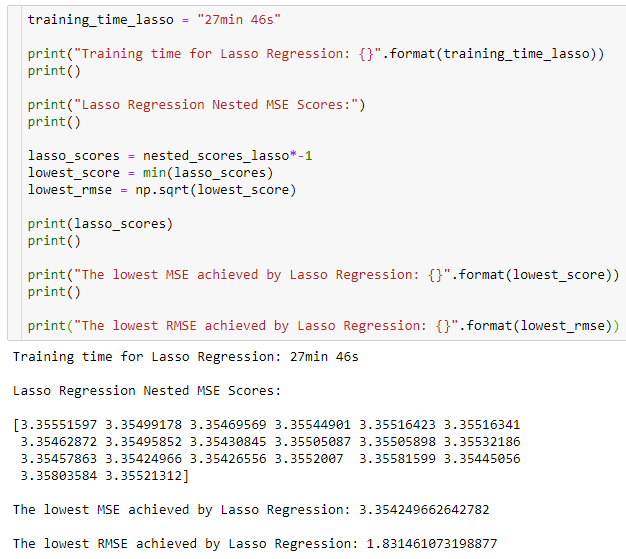

# Two Layer Neural Network Time to Train and MSE/RMSE Scoring

In [69]:
## Import our libraries needed to build the Neural Network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [75]:
## Cycle through these different hidden units for our two layer NN model
nb_hiddens = np.array([128])

## Create a function to build the two layer model
def test_model_two(activation='relu', nb_hidden = 120):
    
    two_layer_model = Sequential()
    
    ## The first hidden layer will cycle through different hidden layers
    ## The model expects rows of data with 7 features (the 'input_dim = 7' argument)
    two_layer_model.add(Dense(nb_hidden, input_dim = 7, activation = "relu"))
    
    ## The second hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    two_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The output layer has one node and uses the linear activation function.
    two_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm "adam". 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    two_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return two_layer_model

In [79]:
## Save our results to an empty list so that we can capture this and plot it later
two_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in nb_hiddens:
    
    ## Establish a new version of our model above
    two_layer_model = test_model_two(nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = two_layer_model.fit(X_train_reg_robust, y_train_reg_robust, epochs = 20, verbose = 0, validation_split = 0.15)
    
    ## Save the results into the list above
    two_layer_model_results.append(history)

In [80]:
## Save the results of our validation MSE to list to bring them back later
first_run_mse_b = two_layer_model_results[0].history['val_mse']

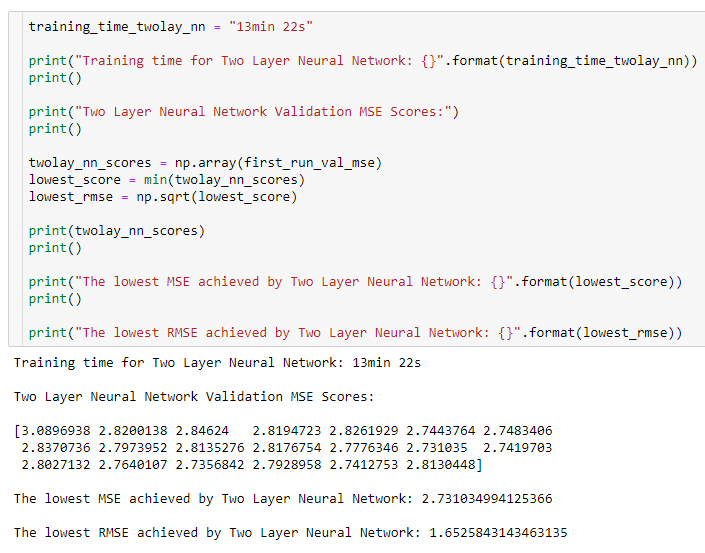

# LG Boost Time to Train and MSE/RMSE Scoring

In [ ]:
## Load our saved model

## lgb_model_loaded(model_file = "LGBModel_Google_Analytics_Customer_Revenue_Regression.txt")

In [23]:
## Import the library that will make our regression problem a cinch!
import lightgbm as lgb

## Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

## Define our own function for calculating the RMSE
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

In [23]:
## Create a function to build our LGB model
## We'll go into detail on each hyper as we build it

def lgb_model(X_train, y_train, X_val, y_val, X_test):
    
    ## Build a dictionary with our parameters
    ## We mimic-ed another sample notebook for some of these parameter settings
    params = {
        
        ## Learning objectives and rates
        "objective": "regression", ## Performing a regression problem
        "metric": "rmse", ## Use rmse, our custom function, as our metric to be used on our evaluation set
        "num_leaves": 40, ## max number of leaves in one tree
        "learning_rate": 0.005, ## also known as shrinkage rate, we go with a low value to give the algorithm better chance to learn
        
        ## Bagging to help with overfitting and to speed up our training
        "bagging_fraction": 0.6, ## Randomly select part of data without replacement to help with overfitting
        "bagging_frequency": 6, ## Perform bagging every 6th iteration
        "bagging_seed": 42, ## Random seed for bagging, 42 because it is the answer to everything
        
        ## Randomly select part of features on each iteration (tree)
        "feature_fraction": 0.6, ## Select 60% of features before training each tree
        
        ## Only warn if there is a "fatal" error
        "verbosity" : -1,
        ## Seed used to generate all other seeds, one seed to rule them all
        "seed": 42
    }
    
    ## First thing that is different about LGB, it takes a different object than our earlier algorithms
    ## LightGBM can load data from csv, txt, numpy arrays, pandas DataFrame - very flexible
    lgb_train_data = lgb.Dataset(X_train, label = y_train)
    lgb_val_data = lgb.Dataset(X_val, label = y_val)
    
    ## Build the actual LGB Model, now that we have set up our parameters, training, and validation data set up
    model = lgb.train(params, ## Parameters for training
                      lgb_train_data, ## Data to be trained on
                     num_boost_round = 5000, ## Number of boosting iterations
                     valid_sets = [lgb_train_data, lgb_val_data], ## List of data to be evaluated on during training
                     early_stopping_rounds = 200, ## Activates early stopping, where the model will training only until validation score stops improving
                     verbose_eval = 500) ## Evaluation metric will be printed on every 500th boosting stage, and the last boosting stage will print
    
    ## Use the model to predict Revenue on our training data
    y_pred_train = model.predict(X_train, num_iteration = model.best_iteration)
    
    ## Use the same model to predict Revenue on our validation data
    y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)
    
    ## Commenting this line from the original function - we'll create a separate one for running against the testing data
##    y_pred_submit = model.predict(X_test, num_iteration = model.best_iteration)
    
    ## Print  out the results of our RMSE function using the training and validation
    print(f"LGBM: RMSE val: {rmse(y_val, y_pred_val)} - RMSE train: {rmse(y_train, y_pred_train)}")
    
    ## Return our predicted values for the validation data, and the final model
    return y_pred_val, model

In [24]:
## Create our "X" variable that contains all the features we would like to use for our model
X = new_train_data

## Create our second "y" variable - for our regression problem using our new target variable
y_regression = target

In [25]:
## Split data training 85 % and testing 15%
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X, y_regression, 
                                                                    test_size = 0.15, random_state = 42)

In [26]:
## Just confirming how much data we have to train and validate against
print("Train shape: {}".format(X_train_reg.shape))
print()
print("Validation shape: {}".format(X_val_reg.shape))

Train shape: (768105, 7)

Validation shape: (135548, 7)


## We're ready to try our newly created model!  We run it twice, to also capture how quickly it is able to perform training and validation concurrently.

## One of the benefits of LGBM is speed - so let's see how it does!

In [ ]:
nested_scores_lgb = [1.66146, 1.63829, ]

In [ ]:
training_time_lgb = "1min 21s"

print("Training time for LGBoost Regression: {}".format(training_time_lgb))
print()

print("Decision Tree Nested MSE Scores:")
print()

dt_scores = nested_scores_dtr*-1
lowest_score = min(dt_scores)
lowest_rmse = np.sqrt(lowest_score)

print(dt_scores)
print()

print("The lowest MSE achieved by Decision Tree: {}".format(lowest_score))
print()

print("The lowest RMSE achieved by Decision Tree: {}".format(lowest_rmse))

In [ ]:
[500]	training's rmse: 1.65597	valid_1's rmse: 1.66146
[1000]	training's rmse: 1.61644	valid_1's rmse: 1.63829
[1500]	training's rmse: 1.59667	valid_1's rmse: 1.63148
[2000]	training's rmse: 1.58229	valid_1's rmse: 1.62939
[2500]	training's rmse: 1.57079	valid_1's rmse: 1.62905
[3000]	training's rmse: 1.56038	valid_1's rmse: 1.62844

In [46]:
%%time

## Train LGBM and generate predictions - get the output
lgb_preds, lgb_model_output = lgb_model(X_train_reg, y_train_reg, 
                               X_val_reg, y_val_reg, X_test_reg)

Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 1.65597	valid_1's rmse: 1.66146
[1000]	training's rmse: 1.61644	valid_1's rmse: 1.63829
[1500]	training's rmse: 1.59667	valid_1's rmse: 1.63148
[2000]	training's rmse: 1.58229	valid_1's rmse: 1.62939
[2500]	training's rmse: 1.57079	valid_1's rmse: 1.62905
[3000]	training's rmse: 1.56038	valid_1's rmse: 1.62844
Early stopping, best iteration is:
[3276]	training's rmse: 1.5551	valid_1's rmse: 1.62817
LGBM: RMSE val: 1.62817 - RMSE train: 1.5551
Wall time: 1min 21s


## 1min21s to train!  Incredible.

In [47]:
## Train LGBM and generate predictions - get the output
lgb_preds, lgb_model_output = lgb_model(X_train_reg, y_train_reg, 
                               X_val_reg, y_val_reg, X_test_reg)

Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 1.65597	valid_1's rmse: 1.66146
[1000]	training's rmse: 1.61644	valid_1's rmse: 1.63829
[1500]	training's rmse: 1.59667	valid_1's rmse: 1.63148
[2000]	training's rmse: 1.58229	valid_1's rmse: 1.62939
[2500]	training's rmse: 1.57079	valid_1's rmse: 1.62905
[3000]	training's rmse: 1.56038	valid_1's rmse: 1.62844
Early stopping, best iteration is:
[3276]	training's rmse: 1.5551	valid_1's rmse: 1.62817
LGBM: RMSE val: 1.62817 - RMSE train: 1.5551
